# Dota predict

Import packages

In [41]:
import pandas as pd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss

Import and clean matches dataframe

In [2]:
#Create a dataframe of matches.
matches = pd.read_csv('Matches.csv')

#Change the winner column display 1 for radiant and 0 for dire.
def winner(side):
    if side == 'Radiant':
        return 1
    if side == 'Dire':
        return 0
matches['Winner'] = matches['Winner'].apply(winner)
matches.tail()

,Match ID,Series,League,Start Date/Time,Match Length,Duration (secs),Kills Score,Unnamed: 7,Winner,Radiant Team,Radiant Players,Dire Team,Dire Players
4995,5041462388,370933.0,11210,26 Sep 2019 03:05,35:56,2156,15-33,"15,33",0,Positive Guys,"Misha, Ghostik, iLTW, Immersion, Ergon",J.Storm,"Moo, Resolut1on, Fear, nine, MoOz"
4996,5041331566,370904.0,11210,26 Sep 2019 01:32,27:45,1665,7-33,"7,33",0,Uvajenie.Hope,"BLACKARXANGEL, chshrct, Bignum, Palantimos, Pi...",Positive Guys,"Misha, Ghostik, iLTW, Immersion, Ergon"
4997,5041252564,370904.0,11210,26 Sep 2019 12:35,33:02,1982,32-15,"32,15",1,Positive Guys,"Misha, Ghostik, iLTW, Immersion, Ergon",Uvajenie.Hope,"BLACKARXANGEL, chshrct, Bignum, Palantimos, Pi..."
4998,5040297210,370693.0,11210,25 Sep 2019 05:50,34:05,2045,17-38,"17,38",0,FlyToMoon,"ALWAYSWANNAFLY, CeMaTheSlayeR, Flow, .Ark, Shisui",Positive Guys,"Misha, Ghostik, iLTW, Immersion, Ergon"
4999,5040149771,370693.0,11210,25 Sep 2019 04:22,53:25,3205,40-32,"40,32",1,Positive Guys,"Misha, Ghostik, iLTW, Immersion, Ergon",FlyToMoon,"ALWAYSWANNAFLY, CeMaTheSlayeR, Flow, .Ark, Shisui"


Import and clean ratings dataframe

In [3]:
#Create a dataframe of ratings of each team from the day of the first recorded match in atches
ratings = pd.read_csv('Initial_Ratings.csv')
ratings.head()

#Clean the names in ratings for easier comparison to matches.
def clean_name(name):
    x = re.split("\(.*\)$", name)
    result = x[0][0:int(((len(x[0])-3)/2))]
    return result
ratings['Unnamed: 0'] = ratings['Unnamed: 0'].apply(clean_name)
ratings.rename(columns={'Unnamed: 0': 'Name'}, inplace=True)
ratings = ratings.drop(ratings.columns[6:],axis=1)
ratings.head()

,Name,Rating,Avg 7d,Δ7d,Avg 30d,Δ30d
0,Team Secret,1322.95,1328.84,0.25,1352.19,-26.55
1,PSG.LGD,1292.62,1299.79,-14.44,1280.82,78.64
2,Fnatic,1225.71,1222.14,-1.13,1219.86,-1.24
3,Vici Gaming,1092.65,1094.92,-4.57,1121.01,-80.99
4,Royal Never Give Up,1071.76,1073.52,-3.54,1099.39,-44.46


Define elo calculating function

In [4]:
#Define a function that calculates the ELOs of two teams having just played a game
def new_elo(elo1, elo2, winner):
    score1 = winner
    score2 = 1 - winner
    E_1 = 1/(1 + pow(10,((elo2 - elo1)/400)))
    E_2 = 1/(1 + pow(10,((elo1 - elo2)/400)))
    new_elo1 = elo1 + 32*(score1 - E_1)
    new_elo2 = elo2 + 32*(score2 - E_2)
    return (new_elo1, new_elo2)

Insert 'rating' columns to the matches dataframe

In [5]:
#Add columns for extra properties
matches['Radiant rating'] = ''
matches['Dire rating'] = ''

#Cycle through the matches adding elos for each team
for row in matches.iloc[::-1].itertuples():
    try:
        elo_radiant = ratings.loc[ratings['Name'] == row[10]]
        radiant_team_number = elo_radiant.index.tolist()[0]
        elo_radiant = elo_radiant.iloc[0][1]
        elo_dire = ratings.loc[ratings['Name'] == row[12]]
        dire_team_number = elo_dire.index.tolist()[0]
        elo_dire = elo_dire.iloc[0][1]
        #print(str(elo_radiant) + ' ' + str(radiant_team_number) + ' vs ' + str(elo_dire) + ' ' + str(dire_team_number))
        
        #compute new elos
        (new_elo_radiant, new_elo_dire) = new_elo(elo_radiant, elo_dire, row[9])
        
        #insert old elos into matches
        matches.iloc[row[0], 13] = elo_radiant
        matches.iloc[row[0], 14] = elo_dire
        
        #update ratings with new elos
        ratings.iloc[radiant_team_number, 1] = new_elo_radiant
        ratings.iloc[dire_team_number, 1] = new_elo_dire
    except:
        pass

#Drop matches where teams are not given ratings
matches = matches.drop(matches[(matches['Radiant rating'] == '')].index)
matches.head()

,Match ID,Series,League,Start Date/Time,Match Length,Duration (secs),Kills Score,Unnamed: 7,Winner,Radiant Team,Radiant Players,Dire Team,Dire Players,Radiant rating,Dire rating
0,5698169969,499522.0,12548,12 Nov 2020 05:00,33:05,1985,21-7,"21,7",1,Team Liquid,"iNSaNiA, Boxi, qojqva, miCKe, Taiga",Natus Vincere,"GeneRaL, ALWAYSWANNAFLY, V-Tune, RodjER, Iceberg",1177.01,1128.74
1,5697990407,499490.0,12548,12 Nov 2020 03:05,31:31,1891,38-13,"38,13",1,Virtus.pro,"DM, epileptick1d, ilias, Save-, gPk~",OG,"n0tail, 7ckngMad, topson, Saksa, MidOne",1133.26,1094.07
2,5697904719,499490.0,12548,12 Nov 2020 02:01,31:04,1864,21-4,"21,4",1,Virtus.pro,"DM, epileptick1d, ilias, Save-, gPk~",OG,"n0tail, 7ckngMad, topson, Saksa, MidOne",1117.62,1109.7
44,5693172834,498327.0,12532,08 Nov 2020 09:24,26:09,1569,21-13,"21,13",1,ViKin.gg,"Seleri, 27monkey, Tobi, Shad, BooM",Team Liquid,"iNSaNiA, Boxi, qojqva, miCKe, Taiga",1134.6,1195.8
46,5693085679,498327.0,12532,08 Nov 2020 08:02,52:27,3147,23-32,"23,32",0,Team Liquid,"iNSaNiA, Boxi, qojqva, miCKe, Taiga",ViKin.gg,"Seleri, 27monkey, Tobi, Shad, BooM",1216.39,1114.02


Insert 'delta7' columnn to dataframe to show change in elo over the last 7 days

In [6]:
#Convert to timestamp format
matches['Start Date/Time'] = pd.to_datetime(matches['Start Date/Time'])

#Find 1 week before the match
def week(date):
    date = date - pd.Timedelta('7D')
    period = pd.Period(date, freq='7D 1H') #extra hour is so that the list of games includes the game itself
    return period

#Find 1 month before the match
def month(date):
    date = date - pd.Timedelta('30D')
    period = pd.Period(date, freq='30D 1H')
    return period

#Find earliest rank within the periods and add them to the dataframe
def delta7(row):
    period_week = week(row[3])
    radiant = row[9]
    current_radiant_rating = row[13]
    current_dire_rating = row[14]
    dire = row[11]
    
    #make in_date to be all games played this week by the team in question
    in_date = matches[matches['Start Date/Time'] < period_week.end_time]
    in_date = in_date[in_date['Start Date/Time'] > period_week.start_time]
    in_date_radiant = in_date[(in_date['Radiant Team'] == radiant) | (in_date['Dire Team'] == radiant)]
    in_date_dire = in_date[(in_date['Radiant Team'] == dire) | (in_date['Dire Team'] == dire)]
    
    #find the index of the earliest of these games
    elo_index_radiant = in_date_radiant.index.tolist()[in_date_radiant.shape[0]-1]
    elo_index_dire = in_date_dire.index.tolist()[in_date_dire.shape[0]-1]
    
    #get the rating from the earliest game
    if matches.loc[elo_index_radiant, 'Radiant Team'] == radiant:
        rating_radiant = matches.loc[elo_index_radiant, 'Radiant rating']
    else:
        rating_radiant = matches.loc[elo_index_radiant, 'Dire rating']
        
    if matches.loc[elo_index_dire, 'Radiant Team'] == dire:
        rating_dire = matches.loc[elo_index_dire, 'Radiant rating']
    else:
        rating_dire = matches.loc[elo_index_dire, 'Dire rating']
    
    rating_dire = matches.loc[elo_index_dire, 'Dire rating']
    
    #get the difference in elo
    rating1 = current_radiant_rating - rating_radiant
    rating2 = current_dire_rating - rating_dire
    return rating1, rating2
    
    
matches['Radiant delta7','Dire delta7'] = matches.apply(delta7, axis=1)
matches.head()

,Match ID,Series,League,Start Date/Time,Match Length,Duration (secs),Kills Score,Unnamed: 7,Winner,Radiant Team,Radiant Players,Dire Team,Dire Players,Radiant rating,Dire rating,"(Radiant delta7, Dire delta7)"
0,5698169969,499522.0,12548,2020-11-12 05:00:00,33:05,1985,21-7,"21,7",1,Team Liquid,"iNSaNiA, Boxi, qojqva, miCKe, Taiga",Natus Vincere,"GeneRaL, ALWAYSWANNAFLY, V-Tune, RodjER, Iceberg",1177.01,1128.74,"(-51.34440853542151, 0.0)"
1,5697990407,499490.0,12548,2020-11-12 03:05:00,31:31,1891,38-13,"38,13",1,Virtus.pro,"DM, epileptick1d, ilias, Save-, gPk~",OG,"n0tail, 7ckngMad, topson, Saksa, MidOne",1133.26,1094.07,"(15.635281958898531, -15.635281958898531)"
2,5697904719,499490.0,12548,2020-11-12 02:01:00,31:04,1864,21-4,"21,4",1,Virtus.pro,"DM, epileptick1d, ilias, Save-, gPk~",OG,"n0tail, 7ckngMad, topson, Saksa, MidOne",1117.62,1109.7,"(0.0, 0.0)"
44,5693172834,498327.0,12532,2020-11-08 09:24:00,26:09,1569,21-13,"21,13",1,ViKin.gg,"Seleri, 27monkey, Tobi, Shad, BooM",Team Liquid,"iNSaNiA, Boxi, qojqva, miCKe, Taiga",1134.6,1195.8,"(62.43232773954219, 93.7566789979453)"
46,5693085679,498327.0,12532,2020-11-08 08:02:00,52:27,3147,23-32,"23,32",0,Team Liquid,"iNSaNiA, Boxi, qojqva, miCKe, Taiga",ViKin.gg,"Seleri, 27monkey, Tobi, Shad, BooM",1216.39,1114.02,"(0.654245237623627, 41.85000843330522)"


In [7]:
#similarly add delta30

#Find earliest rank within the periods and add them to the dataframe
def delta30(row):
    period_month = month(row[3])
    radiant = row[9]
    current_radiant_rating = row[13]
    current_dire_rating = row[14]
    dire = row[11]
    
    #make in_date to be all games played this week by the team in question
    in_date = matches[matches['Start Date/Time'] < period_month.end_time]
    in_date = in_date[in_date['Start Date/Time'] > period_month.start_time]
    in_date_radiant = in_date[(in_date['Radiant Team'] == radiant) | (in_date['Dire Team'] == radiant)]
    in_date_dire = in_date[(in_date['Radiant Team'] == dire) | (in_date['Dire Team'] == dire)]
    
    #find the index of the earliest of these games
    elo_index_radiant = in_date_radiant.index.tolist()[in_date_radiant.shape[0]-1]
    elo_index_dire = in_date_dire.index.tolist()[in_date_dire.shape[0]-1]
    
    #get the rating from the earliest game
    if matches.loc[elo_index_radiant, 'Radiant Team'] == radiant:
        rating_radiant = matches.loc[elo_index_radiant, 'Radiant rating']
    else:
        rating_radiant = matches.loc[elo_index_radiant, 'Dire rating']
        
    if matches.loc[elo_index_dire, 'Radiant Team'] == dire:
        rating_dire = matches.loc[elo_index_dire, 'Radiant rating']
    else:
        rating_dire = matches.loc[elo_index_dire, 'Dire rating']
    
    #get the difference in elo
    rating1 = current_radiant_rating - rating_radiant
    rating2 = current_dire_rating - rating_dire
    return rating1, rating2
    
    
matches['Radiant delta30','Dire delta30'] = matches.apply(delta30, axis=1)

In [8]:
pd.set_option('display.max_rows', 300)

Clean the matches dataframe so that only the necessary data is included for a regression model

In [9]:
#Drop unnecessary columns
matches_simple = matches.drop(columns=['Match ID', 'Series', 'League', 'Start Date/Time', 'Match Length', 'Duration (secs)', 'Kills Score', 'Unnamed: 7', 'Radiant Team', 'Radiant Players', 'Dire Team', 'Dire Players'])
matches_simple.head()

,Winner,Radiant rating,Dire rating,"(Radiant delta7, Dire delta7)","(Radiant delta30, Dire delta30)"
0,1,1177.01,1128.74,"(-51.34440853542151, 0.0)","(63.3638550301464, 51.85245876440558)"
1,1,1133.26,1094.07,"(15.635281958898531, -15.635281958898531)","(15.635281958898531, -85.37422587981155)"
2,1,1117.62,1109.7,"(0.0, 0.0)","(0.0, -69.73894392091302)"
44,1,1134.6,1195.8,"(62.43232773954219, 93.7566789979453)","(57.852067422773416, 99.13652362051494)"
46,0,1216.39,1114.02,"(0.654245237623627, 41.85000843330522)","(119.7188429267519, 37.26974811653645)"


In [10]:
#Find the difference in elo rather than individual scores
def diff(row):
    result = row[1] - row[2]
    return result

matches_simple['Rating Difference'] = matches_simple.apply(diff, axis=1)

#Drop the columns for the scores
matches_simple.drop(columns=['Radiant rating', 'Dire rating'], inplace = True)

matches_simple.head()

,Winner,"(Radiant delta7, Dire delta7)","(Radiant delta30, Dire delta30)",Rating Difference
0,1,"(-51.34440853542151, 0.0)","(63.3638550301464, 51.85245876440558)",48.274978
1,1,"(15.635281958898531, -15.635281958898531)","(15.635281958898531, -85.37422587981155)",39.191688
2,1,"(0.0, 0.0)","(0.0, -69.73894392091302)",7.921124
44,1,"(62.43232773954219, 93.7566789979453)","(57.852067422773416, 99.13652362051494)",-61.201929
46,0,"(0.654245237623627, 41.85000843330522)","(119.7188429267519, 37.26974811653645)",102.366567


In [11]:
#Create a column that get's the difference for each delta column similarly as above
def diff_delta7(row):
    result = row[1][0]-row[1][1]
    return result

matches_simple['delta7'] = matches_simple.apply(diff_delta7, axis=1)

#Drop the old delta7 column
matches_simple.drop(matches_simple.columns[1], axis=1, inplace=True)

matches_simple.head()

,Winner,"(Radiant delta30, Dire delta30)",Rating Difference,delta7
0,1,"(63.3638550301464, 51.85245876440558)",48.274978,-51.344409
1,1,"(15.635281958898531, -85.37422587981155)",39.191688,31.270564
2,1,"(0.0, -69.73894392091302)",7.921124,0.000000
44,1,"(57.852067422773416, 99.13652362051494)",-61.201929,-31.324351
46,0,"(119.7188429267519, 37.26974811653645)",102.366567,-41.195763


In [12]:
#Repeat above with delta30
def diff_delta30(row):
    result = row[1][0]-row[1][1]
    return result

matches_simple['delta30'] = matches_simple.apply(diff_delta30, axis=1)

#Drop the old delta30 column
matches_simple.drop(matches_simple.columns[1], axis=1, inplace=True)

matches_simple.head()

,Winner,Rating Difference,delta7,delta30
0,1,48.274978,-51.344409,11.511396
1,1,39.191688,31.270564,101.009508
2,1,7.921124,0.000000,69.738944
44,1,-61.201929,-31.324351,-41.284456
46,0,102.366567,-41.195763,82.449095


Graphing each column to look for correlation

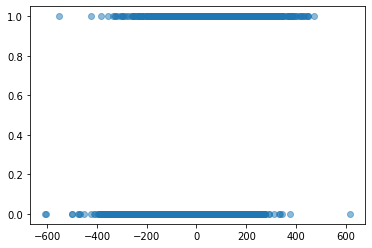

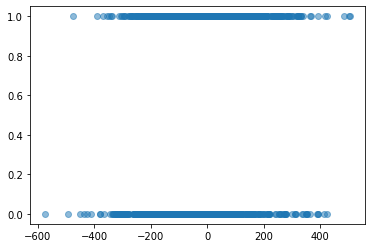

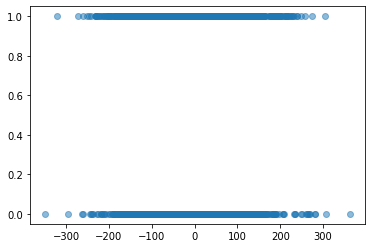

In [13]:
x = matches_simple['Rating Difference']
y = matches_simple['Winner']

plt.scatter(x, y, alpha=0.5)
plt.show()

x = matches_simple['delta7']
y = matches_simple['Winner']

plt.scatter(x, y, alpha=0.5)
plt.show()

x = matches_simple['delta30']
y = matches_simple['Winner']

plt.scatter(x, y, alpha=0.5)
plt.show()


It's hard to tell anything from these although you can just make out a slight lean for a higher rated team to win. Let's see how significant that lean is in each case.

In [14]:
#Just concentrating on rating differences where radiant won.
radiant_rating_difference = matches_simple['Rating Difference'][matches_simple['Winner'] == 1]
#Delta7 radiant win
radiant_delta7 = matches_simple['delta7'][matches_simple['Winner'] == 1]
#Delta30 radiant win
radiant_delta30 = matches_simple['delta30'][matches_simple['Winner'] == 1]

print('Rating difference has mean {} and SD {}'.format(radiant_rating_difference.mean(), radiant_rating_difference.std()))
print('delta7 has mean {} and SD {}'.format(radiant_delta7.mean(), radiant_delta7.std()))
print('delta30 has mean {} and SD {}'.format(radiant_delta30.mean(), radiant_delta30.std()))

Rating difference has mean 53.635466801446405 and SD 140.2834529414935
delta7 has mean 1.9919289461910084 and SD 108.31421361215365
delta30 has mean 2.7071219480056445 and SD 85.98367108712358


Rating difference seems to have the highest impact as expected. Although both other indicators have positive means it's not clear that thay are indeed indicators of a winning team. We'll put this same data into box plots for a more visual presentation.

{'whiskers': [<matplotlib.lines.Line2D at 0x242f17ee0a0>,
 'caps': [<matplotlib.lines.Line2D at 0x242f17ee760>,
 'boxes': [<matplotlib.lines.Line2D at 0x242f17dfd00>,
 'medians': [<matplotlib.lines.Line2D at 0x242f17eee20>,
 'fliers': [<matplotlib.lines.Line2D at 0x242f17f51c0>,
 'means': []}

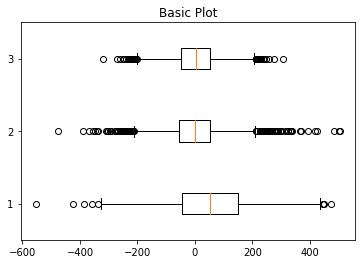

In [15]:
data = [radiant_rating_difference, radiant_delta7, radiant_delta30]
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data, vert = False)

Convert data to numpy arrays for scykit-learn

In [29]:
#Check how many games we are considering
print(matches_simple.shape)

#Define the independant variables array
X = np.asarray(matches_simple[['Rating Difference', 'delta7', 'delta30']])
X = preprocessing.StandardScaler().fit(X).transform(X)

#Define the dependant variables array
y = np.asarray(matches_simple['Winner'])

#Partition the data into train and test segments
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

(2710, 4)
Train set: (2168, 3) (2168,)
Test set: (542, 3) (542,)


In [31]:
#Applu logistic regression to train set
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

#predict results of test set
yhat = LR.predict(X_test)

#find probabilities of each prediction being true
yhat_prob = LR.predict_proba(X_test)

In [42]:
#Evaluate the results with Jaccard similarity score i.e the total correct predictions out of all results in the test data
print('The Jaccard index score is {}'.format(jaccard_score(y_test, yhat)))

#Find the mean accuracy on the given test data and labels
ll = log_loss(y_test, yhat_prob))
print('The log_loss score is {}'.format(ll)

The Jaccard index score is 0.48984771573604063
The log_loss score is 0.6362625701052272


The Jaccard index shows clearly that the predictions are worse than guessing. Similarly with log_loss being above 0.61 gives a prediction average below 0.5.